# Using RNNs to predict time series

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Generating the data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

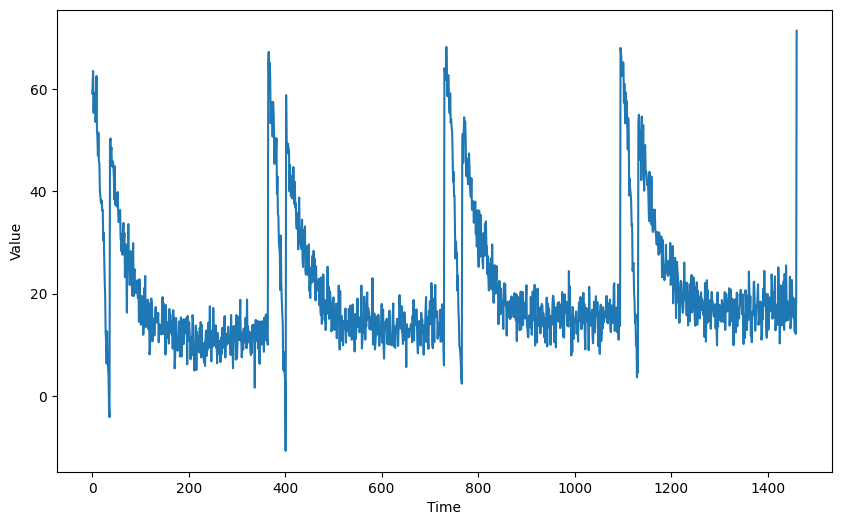

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

In [6]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                                       input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100)
    ])
    return model

In [7]:
# Test the uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 2s 11ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate

In [8]:
def adjust_learning_rate():

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    optimizer = 'adam'

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 10s 33ms/step - loss: 11.2735 - mae: 11.7730 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 31ms/step - loss: 10.3913 - mae: 10.8902 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 35ms/step - loss: 9.4117 - mae: 9.9103 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 2s 58ms/step - loss: 8.3459 - mae: 8.8412 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 1s 33ms/step - loss: 7.2348 - mae: 7.7272 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 31ms/step - loss: 6.1982 - mae: 6.6790 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 31ms/step - loss: 5.4402 - mae: 5.9142 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 32ms/step - loss: 5.0280 - mae: 5.4964 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 1s 32ms/step - loss: 4.8928 - mae: 5.3548 - lr

(1e-06, 1.0, 0.0, 30.0)

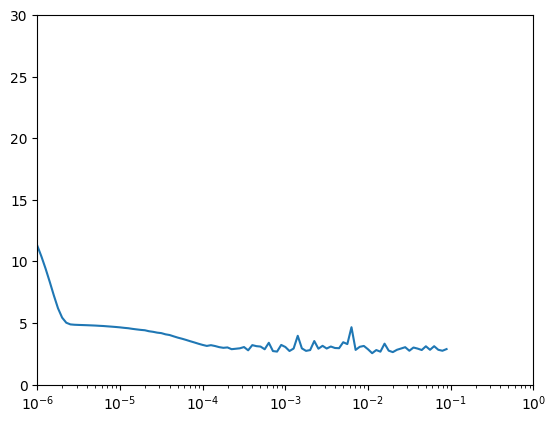

In [10]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

(1e-05, 0.1, 0.0, 10.0)

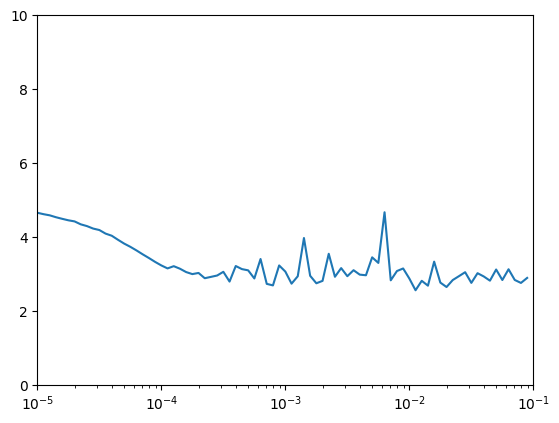

In [11]:
# Zoom in the above graph to determine the optimal learning rate
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 10])

## Compiling the model

In [12]:
def create_model(lr):

    tf.random.set_seed(51)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mae"])

    return model

In [13]:
# Define the optimal learning rate from the above graph
learning_rate = 2e-4

# Create the compiled model
model = create_model(learning_rate)

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 10s 33ms/step - loss: 6.5998 - mae: 7.0719
Epoch 2/50
34/34 [==============================] - 1s 31ms/step - loss: 5.0994 - mae: 5.5659
Epoch 3/50
34/34 [==============================] - 1s 31ms/step - loss: 4.4717 - mae: 4.9407
Epoch 4/50
34/34 [==============================] - 1s 32ms/step - loss: 4.2785 - mae: 4.7479
Epoch 5/50
34/34 [==============================] - 1s 31ms/step - loss: 3.8113 - mae: 4.2845
Epoch 6/50
34/34 [==============================] - 1s 31ms/step - loss: 3.4159 - mae: 3.8764
Epoch 7/50
34/34 [==============================] - 1s 30ms/step - loss: 3.3301 - mae: 3.7965
Epoch 8/50
34/34 [==============================] - 2s 56ms/step - loss: 3.0584 - mae: 3.5251
Epoch 9/50
34/34 [==============================] - 1s 30ms/step - loss: 2.9665 - mae: 3.4354
Epoch 10/50
34/34 [==============================] - 1s 30ms/step - loss: 3.3055 - mae: 3.7725
Epoch 11/50
34/34 [==============================] - 1s 31

## Evaluating the forecast

In [14]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Forecasting using batches of data

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 [==============================] - 2s 10ms/step


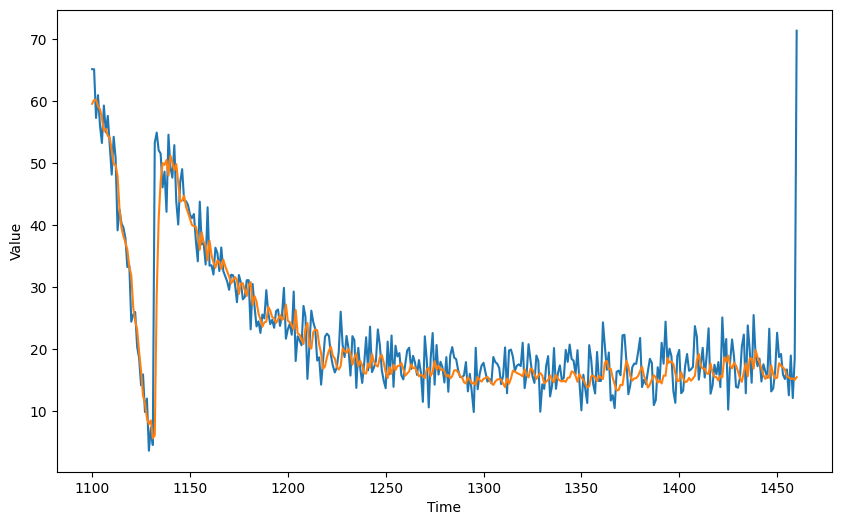

In [16]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 29.62, mae: 3.21 for forecast


## Saving the model

In [18]:
# Save the model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.index
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/assets/
saved_model/my_model/saved_model.pb
saved_model/my_model/fingerprint.pb


In [19]:
# Save the model in HDF5 format
model.save('mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
# Save the model in the native Keras format
model.save('mymodel.keras')

In [46]:
import os

def print_directory_tree(starting_path):
    for root, dirs, files in os.walk(starting_path):
        print(root + os.sep)
        for file in files:
            print(os.path.join(root, file))

print_directory_tree('.')

./
./mymodel.h5
./saved_model.tar.gz
./mymodel.keras
./.config/
./.config/.last_opt_in_prompt.yaml
./.config/config_sentinel
./.config/default_configs.db
./.config/.last_update_check.json
./.config/active_config
./.config/gce
./.config/.last_survey_prompt.yaml
./.config/configurations/
./.config/configurations/config_default
./.config/logs/
./.config/logs/2023.11.01/
./.config/logs/2023.11.01/13.23.08.659551.log
./.config/logs/2023.11.01/13.23.07.863113.log
./.config/logs/2023.11.01/13.22.12.591743.log
./.config/logs/2023.11.01/13.22.49.087752.log
./.config/logs/2023.11.01/13.22.57.692823.log
./.config/logs/2023.11.01/13.22.39.200277.log
./saved_model/
./saved_model/my_model/
./saved_model/my_model/keras_metadata.pb
./saved_model/my_model/saved_model.pb
./saved_model/my_model/fingerprint.pb
./saved_model/my_model/variables/
./saved_model/my_model/variables/variables.index
./saved_model/my_model/variables/variables.data-00000-of-00001
./saved_model/my_model/assets/
./sample_data/
./samp

In [49]:
print('Model file size in HDF5 format: ', os.path.getsize('./mymodel.h5'))
print('Model file size in Keras format: ', os.path.getsize('./mymodel.keras'))
print('Model file size as an archived dir: ', os.path.getsize('./saved_model.tar.gz'))

Model file size in HDF5 format:  471464
Model file size in Keras format:  465547
Model file size as an archived dir:  773537
